# Importing The Libraries

In [8]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


We'll download the images in PNG format from [this page](https://course.fast.ai/datasets), using some helper functions from the `torchvision` and `tarfile` packages.

# Importing and Preprocessing

In [2]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

In [3]:
# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

## Initial Data Visualizing

In [4]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['train', 'test']
['deer', 'cat', 'horse', 'ship', 'frog', 'dog', 'truck', 'bird', 'airplane', 'automobile']


In [30]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())
test=ImageFolder(data_dir+'/test', transform=ToTensor())

In [9]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  airplane (0)


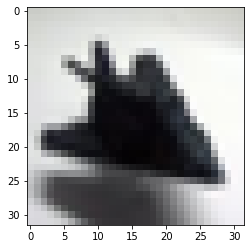

In [10]:
show_example(*dataset[0])

In [33]:

train_ds= dataset
val_ds= test
len(train_ds), len(val_ds)

(50000, 10000)

In [17]:
img,label=train_ds[0]
img.shape

torch.Size([3, 32, 32])

In [34]:
from torch.utils.data.dataloader import DataLoader

batch_size=128
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [35]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

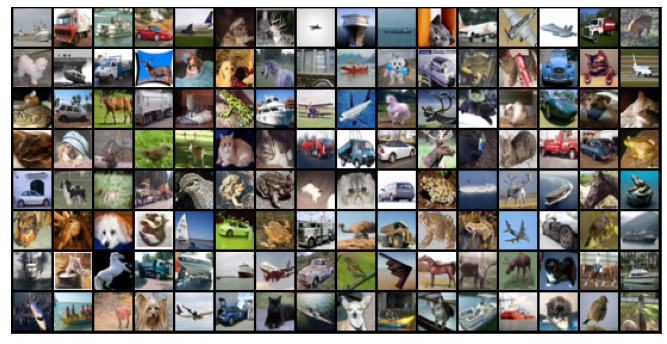

In [36]:
show_batch(train_dl)

Let's define the model by extending an ImageClassificationBase class which contains helper methods for training & validation.

# Model Creation

In [20]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

## Net A

In [21]:
class NetA(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Flatten(), #flatten to vector
            nn.Linear(3*32*32,10))        
    def forward(self, xb):
        return self.network(xb)

## Net B

In [37]:
class NetB(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Flatten(),           #flatten to vector
            nn.Linear(3*32*32,300), #hidden layer
            nn.ReLU(),              # Activation function
            nn.Linear(300,10))      # Output Layer
    def forward(self, xb):
        return self.network(xb)

## Net C

In [80]:
class NetC(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 25, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d((2, 2),stride=2),

            nn.Flatten(),           #flatten to vector
            nn.Linear(4900,1000), #hidden layer
            nn.ReLU(),              # Activation function
            nn.Linear(1000,10))      # Output Layer
    def forward(self, xb):
        return self.network(xb)


## Evaluation and fitting codes

In [40]:
@torch.no_grad()  #tells we dont want to perform any gradient
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [41]:
model_NetA = NetA()
model_NetA

NetA(
  (network): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=10, bias=True)
  )
)

In [50]:
model_NetB = NetB()
model_NetB

NetB(
  (network): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=300, bias=True)
    (2): ReLU()
    (3): Linear(in_features=300, out_features=10, bias=True)
  )
)

In [51]:
model_NetC = NetC()
model_NetC

NetC(
  (network): Sequential(
    (0): Conv2d(3, 25, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=200, out_features=300, bias=True)
    (5): ReLU()
    (6): Linear(in_features=300, out_features=10, bias=True)
  )
)

# Utilizing GPU and transferring DataLoaders and Models

In [46]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [47]:
device = get_default_device()
device

device(type='cuda')

## DataLoader transfer

In [64]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

# Training Models

## Training Net A

In [65]:
model = to_device(NetA(), device)

In [66]:
num_epochs = 50
opt_func = torch.optim.Adam
lr = 0.001

In [67]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.9229, val_loss: 1.8488, val_acc: 0.3495
Epoch [1], train_loss: 1.8197, val_loss: 1.8069, val_acc: 0.3681
Epoch [2], train_loss: 1.7879, val_loss: 1.8061, val_acc: 0.3746
Epoch [3], train_loss: 1.7811, val_loss: 1.7721, val_acc: 0.3808
Epoch [4], train_loss: 1.7673, val_loss: 1.8126, val_acc: 0.3552
Epoch [5], train_loss: 1.7629, val_loss: 1.7986, val_acc: 0.3767
Epoch [6], train_loss: 1.7526, val_loss: 1.7444, val_acc: 0.3844
Epoch [7], train_loss: 1.7495, val_loss: 1.7473, val_acc: 0.3870
Epoch [8], train_loss: 1.7373, val_loss: 1.8056, val_acc: 0.3789
Epoch [9], train_loss: 1.7389, val_loss: 1.7985, val_acc: 0.3792
Epoch [10], train_loss: 1.7394, val_loss: 1.7887, val_acc: 0.3751
Epoch [11], train_loss: 1.7257, val_loss: 1.7408, val_acc: 0.3944
Epoch [12], train_loss: 1.7255, val_loss: 1.7708, val_acc: 0.3850
Epoch [13], train_loss: 1.7190, val_loss: 1.7582, val_acc: 0.3807
Epoch [14], train_loss: 1.7188, val_loss: 1.7754, val_acc: 0.3784
Epoch [15], train_lo

## Training Net B

In [81]:
model = to_device(NetB(), device)

In [73]:
history2 = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.8690, val_loss: 1.7356, val_acc: 0.3905
Epoch [1], train_loss: 1.6943, val_loss: 1.7619, val_acc: 0.3873
Epoch [2], train_loss: 1.6231, val_loss: 1.5805, val_acc: 0.4316
Epoch [3], train_loss: 1.5681, val_loss: 1.5849, val_acc: 0.4348
Epoch [4], train_loss: 1.5327, val_loss: 1.5271, val_acc: 0.4604
Epoch [5], train_loss: 1.5003, val_loss: 1.4998, val_acc: 0.4688
Epoch [6], train_loss: 1.4755, val_loss: 1.6038, val_acc: 0.4334
Epoch [7], train_loss: 1.4579, val_loss: 1.5708, val_acc: 0.4411
Epoch [8], train_loss: 1.4374, val_loss: 1.4610, val_acc: 0.4841
Epoch [9], train_loss: 1.4194, val_loss: 1.4361, val_acc: 0.4924
Epoch [10], train_loss: 1.4020, val_loss: 1.4692, val_acc: 0.4759
Epoch [11], train_loss: 1.3928, val_loss: 1.4627, val_acc: 0.4797
Epoch [12], train_loss: 1.3743, val_loss: 1.4302, val_acc: 0.4896
Epoch [13], train_loss: 1.3644, val_loss: 1.4229, val_acc: 0.4944
Epoch [14], train_loss: 1.3466, val_loss: 1.4172, val_acc: 0.4974
Epoch [15], train_lo

## Training Net C

In [82]:
model = to_device(NetC(), device)

In [83]:
history3 = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.4910, val_loss: 1.2682, val_acc: 0.5404
Epoch [1], train_loss: 1.1695, val_loss: 1.1064, val_acc: 0.6038
Epoch [2], train_loss: 1.0209, val_loss: 1.0999, val_acc: 0.6195
Epoch [3], train_loss: 0.8896, val_loss: 1.0725, val_acc: 0.6271
Epoch [4], train_loss: 0.7741, val_loss: 0.9936, val_acc: 0.6569
Epoch [5], train_loss: 0.6681, val_loss: 0.9836, val_acc: 0.6651
Epoch [6], train_loss: 0.5587, val_loss: 1.0152, val_acc: 0.6672
Epoch [7], train_loss: 0.4578, val_loss: 1.0730, val_acc: 0.6567
Epoch [8], train_loss: 0.3706, val_loss: 1.0843, val_acc: 0.6698
Epoch [9], train_loss: 0.2811, val_loss: 1.2055, val_acc: 0.6591
Epoch [10], train_loss: 0.2121, val_loss: 1.2486, val_acc: 0.6693
Epoch [11], train_loss: 0.1597, val_loss: 1.3899, val_acc: 0.6592
Epoch [12], train_loss: 0.1181, val_loss: 1.4649, val_acc: 0.6651
Epoch [13], train_loss: 0.0923, val_loss: 1.6132, val_acc: 0.6562
Epoch [14], train_loss: 0.0691, val_loss: 1.8073, val_acc: 0.6427
Epoch [15], train_lo

# Plots and Accuracies of Models

In [74]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

## Plots of accuracies and loss

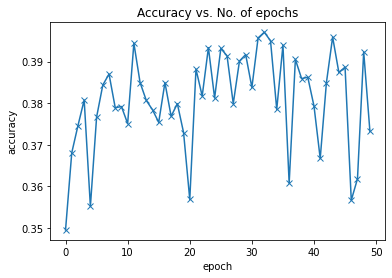

In [72]:
plot_accuracies(history) #NetA

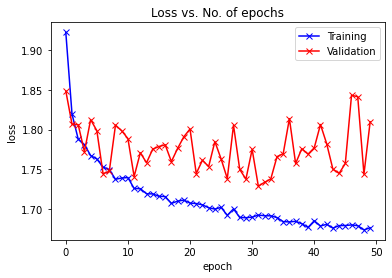

In [75]:
plot_losses(history) #NetA

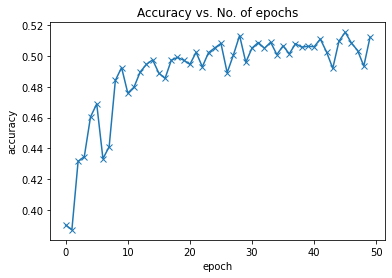

In [76]:
plot_accuracies(history2) #NetB

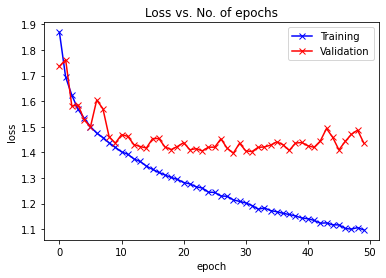

In [77]:
plot_losses(history2) #NetB

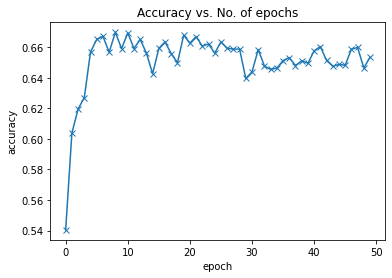

In [84]:
plot_accuracies(history3) #NetC

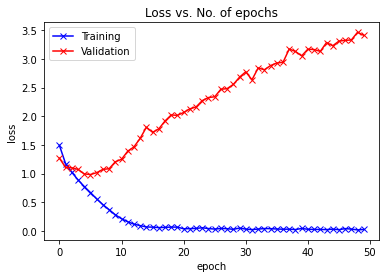

In [85]:
plot_losses(history3) #NetC

## Test Accuracy and Loss

In [88]:
# Accuracy and Loss for NetA
test_loader = DeviceDataLoader(DataLoader(valid_ds, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.3732145149017429, 'val_loss': 1.809907450247471}


In [87]:
# Accuracy and Loss for NetB
test_loader = DeviceDataLoader(DataLoader(valid_ds, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.5120179649012423, 'val_loss': 1.436706450474893}


In [86]:
# Accuracy and Loss for NetC
test_loader = DeviceDataLoader(DataLoader(valid_ds, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.6534179449081421, 'val_loss': 3.409397840499878}